In [1]:
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image
import cv2
import matplotlib.pyplot as plt



In [2]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/firmware.csv')
data = data.iloc[:,:-1]

data.head()

Mounted at /content/drive


,filename,class,target,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,...,pixel1015,pixel1016,pixel1017,pixel1018,pixel1019,pixel1020,pixel1021,pixel1022,pixel1023,pixel1024
0,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,malware,1,85,17,34,34,0,17,17,...,0,0,0,0,0,0,0,0,0,0
1,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,malware,1,85,17,34,34,0,17,17,...,0,0,51,0,0,0,34,0,0,0
2,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,malware,1,85,17,34,34,0,17,17,...,0,0,0,0,0,0,0,0,0,0
3,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,malware,1,85,17,34,34,0,17,17,...,0,0,51,0,0,0,34,0,0,0
4,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,malware,1,85,17,34,34,0,17,17,...,0,0,0,0,0,0,0,0,0,0


In [3]:
pixel_data = data.iloc[:, 3:].values

In [4]:
# check if data size is a multiple of 1024
if pixel_data.size % 1024 != 0:
    raise ValueError("not a multiple of 1024")

num_images = pixel_data.shape[0]
pixels = pixel_data.reshape(num_images, 32, 32, 1) / 255.0
targets = to_categorical(data['target'].values)


In [5]:
x_train, x_test, y_train, y_test = train_test_split(pixels, targets, test_size=0.35, random_state=42)

# build the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(data['target'])), activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=1, verbose=0, mode='auto')

# fit the model
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), callbacks=[earlystop])

# evaluation
loss, accuracy = model.evaluate(x_test, y_test)
print('loss:', loss)
print('accuracy:', accuracy)


Epoch 1/5
790/790 [==============================] - 20s 24ms/step - loss: 0.0916 - accuracy: 0.9788 - val_loss: 0.0421 - val_accuracy: 0.9838
Epoch 2/5
790/790 [==============================] - 20s 25ms/step - loss: 0.0335 - accuracy: 0.9874 - val_loss: 0.0147 - val_accuracy: 0.9935
Epoch 3/5
790/790 [==============================] - 20s 26ms/step - loss: 0.0159 - accuracy: 0.9946 - val_loss: 0.0076 - val_accuracy: 0.9971
Epoch 4/5
426/426 [==============================] - 3s 6ms/step - loss: 0.0052 - accuracy: 0.9985
loss: 0.005180301610380411
accuracy: 0.9985306262969971


In [6]:
# now let's obfuscate
def add_noise(dataset, noise_factor=0.4):
    dataset_noisy = dataset + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=dataset.shape)
    dataset_noisy = np.clip(dataset_noisy, 0., 1.)
    return dataset_noisy

pixels_add_noise = add_noise(pixels)

def blur_images(images, kernel_size=(5, 5)):
    blurred_images = np.empty(images.shape)
    for i, img in enumerate(images):
        img_2d = img.reshape(img.shape[:-1])
        blurred_img_2d = cv2.GaussianBlur(img_2d, kernel_size, 0)
        blurred_images[i] = blurred_img_2d.reshape(img.shape)
    return blurred_images

pixels_blurred = blur_images(pixels_add_noise)

def pixelate_images(images, reduction_factor=0.6):
    pixelated_images = np.empty(images.shape)
    for i, img in enumerate(images):
        img_2d = img.reshape(img.shape[:-1])
        small_img_2d = resize(img_2d, (int(img_2d.shape[0] * reduction_factor), int(img_2d.shape[1] * reduction_factor)), mode='reflect')
        pixelated_img_2d = resize(small_img_2d, img_2d.shape, mode='reflect')
        pixelated_images[i] = pixelated_img_2d.reshape(img.shape)
    return pixelated_images

pixels_pixelated = pixelate_images(pixels_blurred)



In [7]:
# split the noisy data
x_train_noisy, x_test_noisy, y_train_noisy, y_test_noisy = train_test_split(pixels_pixelated, targets, test_size=0.35, random_state=42)

# build the model
model_obf = Sequential()
model_obf.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
model_obf.add(MaxPooling2D(pool_size=(2, 2)))
model_obf.add(Dropout(0.5))
model_obf.add(Flatten())
model_obf.add(Dense(64, activation='relu'))
model_obf.add(Dropout(0.5))
model_obf.add(Dense(len(np.unique(data['target'])), activation='softmax'))

# compile the model
model_obf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=1, verbose=0, mode='auto')
model_obf.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), callbacks=[earlystop])

# evaluation
loss_noisy, accuracy_noisy = model_obf.evaluate(x_test_noisy, y_test_noisy)
print('loss with noisy data:', loss_noisy)
print('accuracy with noisy data:', accuracy_noisy)

Epoch 1/5
790/790 [==============================] - 21s 26ms/step - loss: 0.0918 - accuracy: 0.9793 - val_loss: 0.0415 - val_accuracy: 0.9844
Epoch 2/5
790/790 [==============================] - 19s 24ms/step - loss: 0.0343 - accuracy: 0.9879 - val_loss: 0.0191 - val_accuracy: 0.9898
Epoch 3/5
790/790 [==============================] - 20s 26ms/step - loss: 0.0179 - accuracy: 0.9928 - val_loss: 0.0057 - val_accuracy: 0.9972
Epoch 4/5
426/426 [==============================] - 3s 8ms/step - loss: 0.5461 - accuracy: 0.9791
loss with noisy data: 0.5461276173591614
accuracy with noisy data: 0.9791345000267029


426/426 [==============================] - 3s 6ms/step


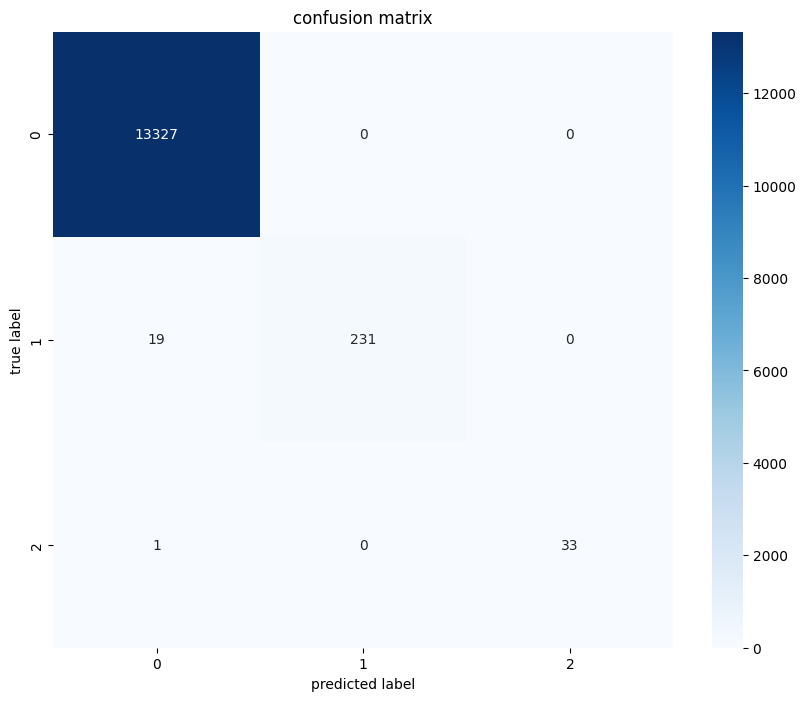

In [8]:
# confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title("confusion matrix")
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.show()

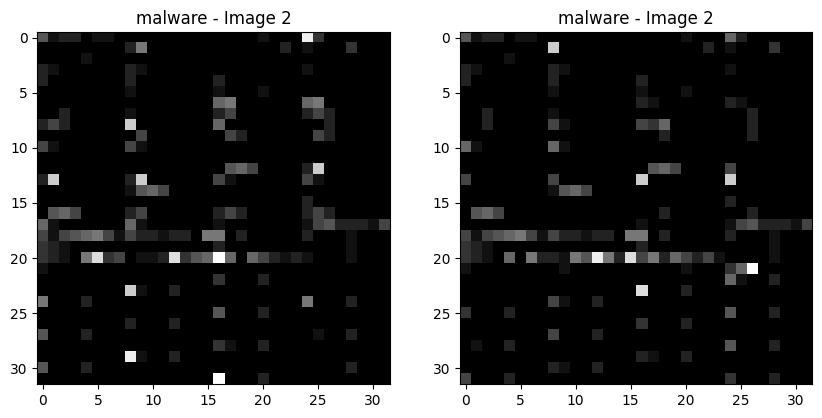

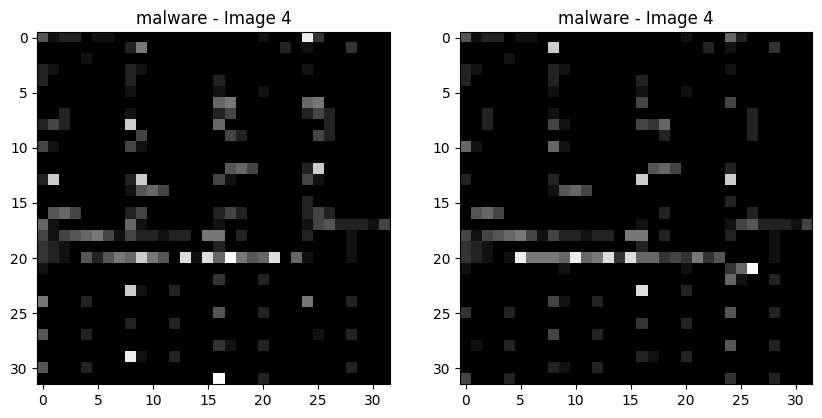

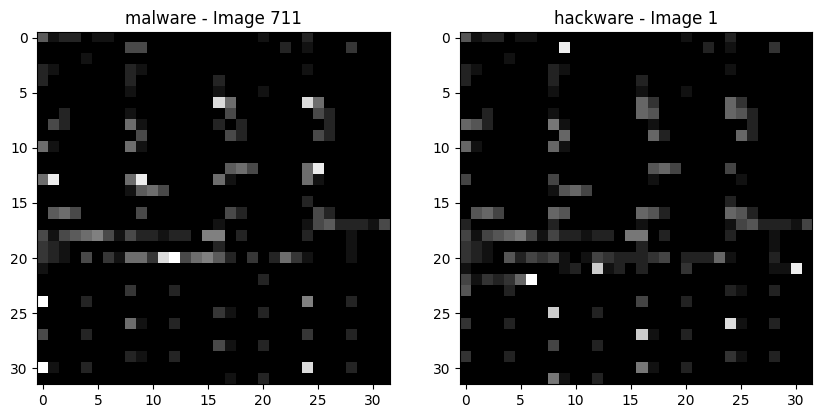

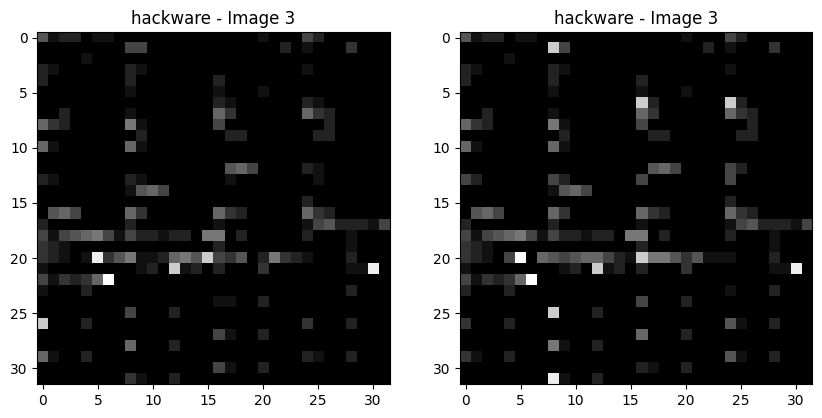

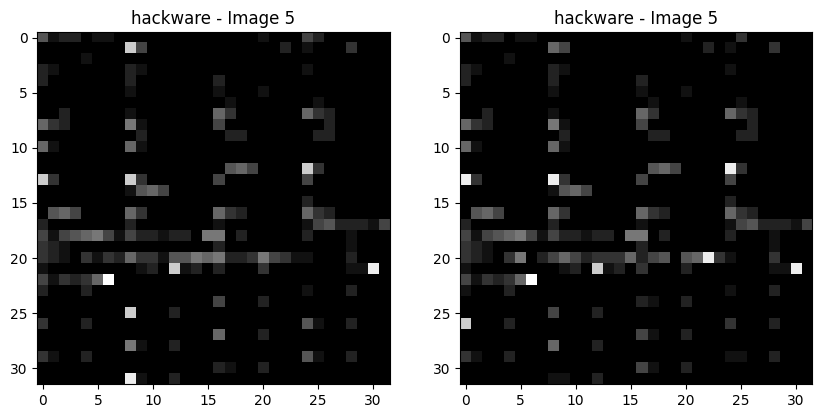

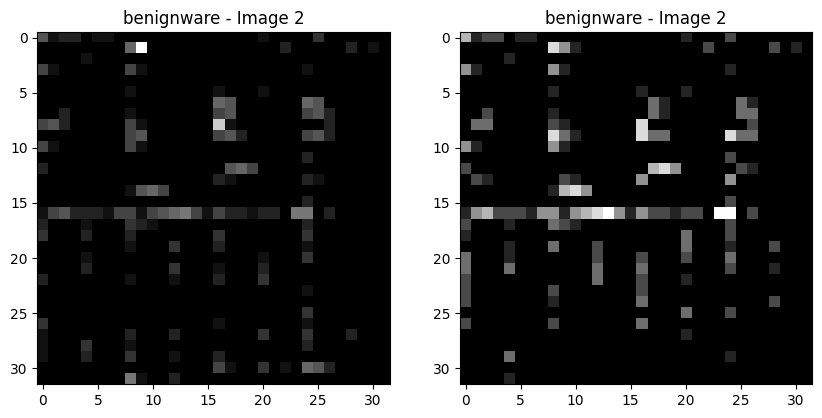

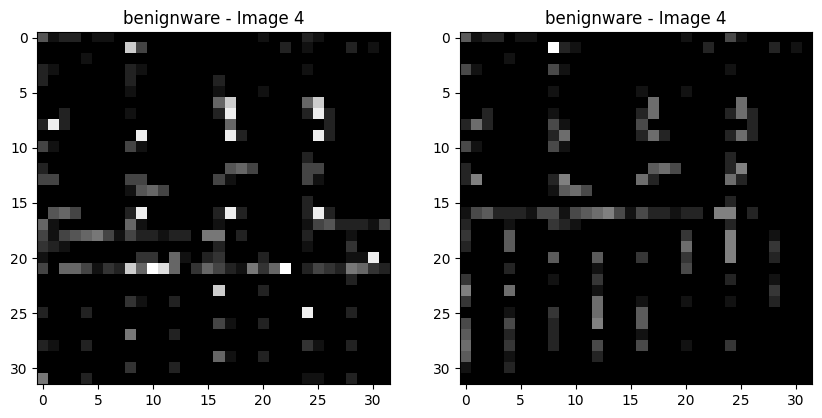

In [9]:
class_counts = dict()

temp_pixel_data = None
temp_class_name = None

for pixel_data, class_name in zip(pixels, data['class']):
    
    pixel_data = np.squeeze(pixel_data)

    class_counts[class_name] = class_counts.get(class_name, 0) + 1
    if class_counts[class_name] > 5:
        continue
    
    if temp_pixel_data is None:
        temp_pixel_data = pixel_data
        temp_class_name = class_name
    else:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].set_title(f"{temp_class_name} - Image {class_counts[temp_class_name]}")
        axs[0].imshow(temp_pixel_data, cmap='gray')

        axs[1].set_title(f"{class_name} - Image {class_counts[class_name]}")
        axs[1].imshow(pixel_data, cmap='gray')

        plt.show()

        temp_pixel_data = None
        temp_class_name = None